In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM
import preprocessing 
np.random.seed(7)

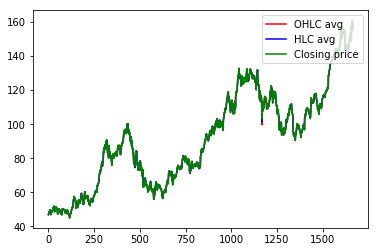

In [12]:
# IMPORTING DATASET 
dataset = pd.read_csv('apple_share_price.csv', usecols=[1,2,3,4])
dataset = dataset.reindex(index = dataset.index[::-1])

# CREATING OWN INDEX FOR FLEXIBILITY
obs = np.arange(1, len(dataset) + 1, 1)

# TAKING DIFFERENT INDICATORS FOR PREDICTION
OHLC_avg = dataset.mean(axis = 1)
HLC_avg = dataset[['High', 'Low', 'Close']].mean(axis = 1)
close_val = dataset[['Close']]

# PLOTTING ALL INDICATORS IN ONE PLOT
plt.plot(obs, OHLC_avg, 'r', label = 'OHLC avg')
plt.plot(obs, HLC_avg, 'b', label = 'HLC avg')
plt.plot(obs, close_val, 'g', label = 'Closing price')
plt.legend(loc = 'upper right')
plt.show()

In [13]:
# PREPARATION OF TIME SERIES DATASET
OHLC_avg = np.reshape(OHLC_avg.values, (len(OHLC_avg),1)) # 1664
scaler = MinMaxScaler(feature_range=(0, 1))
OHLC_avg = scaler.fit_transform(OHLC_avg)

# TRAIN-TEST SPLIT
train_OHLC = int(len(OHLC_avg) * 0.75)
test_OHLC = len(OHLC_avg) - train_OHLC
train_OHLC, test_OHLC = OHLC_avg[0:train_OHLC,:], OHLC_avg[train_OHLC:len(OHLC_avg),:]

# TIME-SERIES DATASET (FOR TIME T, VALUES FOR TIME T+1)
trainX, trainY = preprocessing.new_dataset(train_OHLC, 1)
testX, testY = preprocessing.new_dataset(test_OHLC, 1)

# RESHAPING TRAIN AND TEST DATA
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
step_size = 1

In [ ]:
# LSTM MODEL
model = Sequential()
model.add(LSTM(64, input_shape=(1, step_size), return_sequences = True))
model.add(LSTM(32))

model.add(Dense(1))
model.add(Activation('linear'))

# MODEL COMPILING AND TRAINING
model.compile(loss='mean_squared_error', optimizer='adagrad') # Try SGD, adam, adagrad and compare!!!
history = model.fit(trainX, trainY, epochs=50, batch_size=1, verbose=2)

model.reset_metrics()


# PREDICTION
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

#save_model
model.save('sp.h5')


Epoch 1/50
 - 6s - loss: 0.0026
Epoch 2/50
 - 5s - loss: 2.5914e-04
Epoch 3/50


In [ ]:
# DE-NORMALIZING FOR PLOTTING
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])


# TRAINING RMSE
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train RMSE: %.2f' % (trainScore))

# TEST RMSE
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test RMSE: %.2f' % (testScore))

# CREATING SIMILAR DATASET TO PLOT TRAINING PREDICTIONS
trainPredictPlot = np.empty_like(OHLC_avg)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[step_size:len(trainPredict)+step_size, :] = trainPredict

# CREATING SIMILAR DATASSET TO PLOT TEST PREDICTIONS
testPredictPlot = np.empty_like(OHLC_avg)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(step_size*2)+1:len(OHLC_avg)-1, :] = testPredict

# DE-NORMALIZING MAIN DATASET 
OHLC_avg = scaler.inverse_transform(OHLC_avg)

In [ ]:
# PLOT OF MAIN OHLC VALUES, TRAIN PREDICTIONS AND TEST PREDICTIONS
plt.plot(OHLC_avg, 'g', label = 'original dataset')
plt.plot(trainPredictPlot, 'r', label = 'training set')
plt.plot(testPredictPlot, 'b', label = 'predicted stock price/test set')
plt.legend(loc = 'upper right')
plt.xlabel('Time in Days')
plt.ylabel('OHLC Value of Apple Stocks')
plt.show()


In [ ]:
# PREDICT FUTURE VALUES
last_val = testPredict[-1]
print(last_val)
last_val_scaled = last_val/last_val
next_val = model.predict(np.reshape(last_val_scaled, (1,1,1)))
print("Last Day Value:", np.asscalar(last_val))
print("Next Day Value:", np.asscalar(last_val*next_val))